In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from math import ceil
from pylab import rcParams
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score as r2

%matplotlib inline
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 8

In [93]:
train_data = pd.read_csv('train.csv')

train_data.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9523,1120,129,3.0,60.459577,32.259495,7.0,2,4.0,1954,0.460556,B,B,20,4386,14,NaN,1,5,B,296102.796034
6213,5984,44,1.0,37.765731,21.014132,6.0,2,9.0,1979,0.232205,B,B,24,4860,1,80.0,0,3,B,189400.558860
3347,8605,39,2.0,47.976058,32.969176,6.0,8,9.0,1975,0.428826,B,B,25,5011,8,730.0,0,2,B,183807.961081
5236,8660,94,1.0,40.331178,20.318579,9.0,8,16.0,1977,0.282798,B,B,33,8667,2,NaN,0,6,B,155930.413124
6236,327,1,1.0,43.313080,23.034625,8.0,13,14.0,1990,0.025609,B,B,33,5261,0,240.0,3,1,B,162643.299925
1855,9439,42,3.0,90.991522,53.685708,10.0,8,24.0,2010,0.158249,B,B,21,5731,0,NaN,1,0,B,282322.982451
4453,13853,27,2.0,59.826245,NaN,1.0,6,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,139272.571419
6200,830,6,1.0,43.497305,NaN,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,126080.571224
9238,8576,4,2.0,53.179791,50.643797,5.0,5,12.0,1976,0.042032,B,B,37,6856,84,1940.0,2,5,B,308108.233873
3026,15138,169,3.0,78.119500,NaN,1.0,4,16.0,2015,0.178917,B,B,18,3594,4,192.0,1,5,B,326786.673447


### Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Exploratory data analysis

Когда изучаются вещественные признаки, то обязательно надо посмотреть на основные статистики с помощью describe(). Во-первых можно понять где есть пропуски, с помощью count - если здесь не 10000, значит есть пропуски. Далее подсчитываеться средняя mean, а вот среднюю стоит сравнивать с медианой 50%, потому что если они отличаются, значит где-то есть выбросы. Так же здесь стоит посмотреть на минимальные - максимальные значения. Здесь хорошо видны неадекватные значения.

In [95]:
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [96]:
# кол-во значений в признаках
# переведем признаки с небльшим кол-во значений в категориальные
pd.DataFrame({item:len(train_data[item].unique()) for item in train_data[train_data.columns.tolist()]}.items(), \
columns = ['Name', 'Count']).sort_values(by='Count')

,Name,Count
18,Shops_2,2
10,Ecology_2,2
11,Ecology_3,2
16,Helthcare_2,7
2,Rooms,9
17,Shops_1,16
14,Social_3,30
6,Floor,33
7,HouseFloor,44
12,Social_1,51


### класс конвейера
Target Encoder для задачи регрессии использует среднее значение целевой метки по данному значению категориального признака.
Важно понимать, что для тестовой выборки кодирования производится значениями, полученными на обучающей выборке. Поэтому, важно смотреть за статистической схожестью выборок, в противном случае теряется главный плюс данного кодирования - сохранение исходной зависимости между признаком и целевой меткой во время кодирования.

In [97]:
class DataFrame(pd.DataFrame):
    """расширение DataFrame"""
    @property    
    def column_num(self):
        """количественные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['uint8', 'int32', 'int64', 'float32', 'float64']).columns.tolist()
        
    @property    
    def column_cat(self):
        """номинативные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['object', 'category']).columns.tolist()    
    
class DataPipeline:     
    def __init__(self, **kwargs):
        """Инициализация класса"""                 
        # уровень стат значимости
        self.alpha = 0.05
        # срнднйи уровень корреляции
        self.corr = 0.7
        # пороговое значение в три сигмы
        self.threashold = 3    
        # пропорции деления набора
        self.test_size = .33
        # параметры класса
        for key, value in kwargs.items():
            setattr(self, key, value)                        
            
        assert self.train_file is not None
        self.train_data = DataFrame(pd.read_csv(self.train_file))
        
        assert self.test_file is not None                   
        self.test_data = DataFrame(pd.read_csv(self.test_file))
        
        assert self.feature is not None           
    
    def sc_data(func):
        """Декоратор стандартизации"""
        def wrapper(self):         
            scaler = StandardScaler()                                                            
            # стандартизация обучения                    
            self.sc_train_data = func(self, self.train_data)
            # нормированная целевая переменная
            self.train_data[self.target] = self.sc_train_data[self.target]
            # исключение целевой переменной из количественных признаков
            column = [item for item in self.sc_train_data.column_num if item != self.target]                                       
            # стандартизация признаков                            
            self.sc_train_data = DataFrame(pd.concat([DataFrame(scaler.fit_transform(self.sc_train_data[column]), columns=column),\
                                                      self.sc_train_data[self.sc_train_data.column_cat]], axis=1))            
            print("train resize")
            # понижение размерности                   
            self.sc_train_data = DataFrame(self.resize(self.sc_train_data))                        
                        
            # стандартизация теста            
            self.sc_test_data = func(self, self.test_data)                             
            # стандартизация признаков            
            self.sc_test_data = DataFrame(pd.concat([DataFrame(scaler.transform(self.sc_test_data[self.sc_test_data.column_num]),\
                                                     columns=self.sc_test_data.column_num), self.sc_test_data[self.sc_test_data.column_cat]], axis=1))                         
            print("test resize")         
            # понижение размерности            
            self.sc_test_data = DataFrame(self.resize(self.sc_test_data))                        
                        
        return wrapper    
    
    @sc_data
    def transform(self, data):       
        """Трансформация данных"""       
            
        # удаляем id
        data.drop("Id", axis=1, inplace=True, errors="ignore")            
        # значений не много переводим в категориальный тип
        data.DistrictId = data.DistrictId.astype("category")                
        data.Social_3 = data.Social_3.astype("category")                    
        data.Helthcare_2  = data.Helthcare_2.astype("category")        
        
        # заменяем inf на nan тогда моедль сможет их предсказать
        data.replace([np.inf, -np.inf], np.nan, inplace = True)
        
        # добавление признаков
        data = self.feature.create(data, self.target)              

        # обработка номинальных признаков
        for item in data.column_cat:        
            data = self._transform_cat_(data, item)            
        
        # обработка количественных признаков
        for item in data.column_num:
            data = self._transform_num_(data, item)                                
        
        return data
            
    def _transform_cat_(self, data, column):
        """Трансформация номинальных признаков"""                
        # заменяем пропуски модой                                   
        data[column] = data[column].fillna(data[column].mode()[0])                    
        # кодируем признак
        data[column] = LabelEncoder().fit_transform(data[column])
        # возвращаем тип признака из числового после кодирования
        data[column] = data[column].astype("category")
        
        return data
        
    def _transform_num_(self, data, column):        
        """Трансформация количественных признаков"""        
        # пробуем предсказать пропуски                        
        cdata = DataFrame(data.copy()) 
        # запомнинание пропусков        
        cdata['isna'] = np.where(cdata[column].isna(), True, False)                                             
        # заполнение пропусков в копии, т.к моедель не работает с ними
        for item in cdata.column_cat:
            cdata[item] = cdata.fillna(cdata[item].mode())        
        for item in cdata.column_num:
            cdata[item] = cdata.fillna(cdata[item].mean())                   
        # предсказание пропусков
        if True in cdata['isna'].values:
            # используем простую модель
            model = LinearRegression()
            # формируем тестовый и обучающий набор
            X_test = cdata[cdata['isna']==True][[item for item in cdata.columns if item != column]]
            X_train = cdata[cdata['isna']==False][[item for item in cdata.columns if item != column]]        
            y_train = cdata[cdata['isna']==False][[column]]        
            # обучение модели
            model.fit(X_train, y_train)
            # выполняем предсказание пропущенного прзнака        
            data.loc[cdata['isna'], [column]] = model.predict(X_test)                                      
        
        # очень странно, если не трогать целевую переменную или выполнить винсоризацию
        # то результат обучения модели существенно лучше, хотя мат статистика по ней хуже чем после zscore?
        #if column == self.target:
        #    data[column] = winsorize(data[column], limits=[0.1, 0.1])                                                    
        #    return data
        
        # обработка выбрасов, вычисляем z-Score в цикле пока не подавим их все       
        while True:            
            z = np.abs(stats.zscore(data[column]))                                                     
            if not z[z > self.threashold].any():
                break            
            # среднее если данные имеют нормальное распределение, иначе медиана                                    
            if stats.shapiro(data[column].values.reshape(-1))[1] > self.alpha:                        
                data.loc[z > self.threashold, column] = data[column].mean()            
            else:            
                data.loc[z > self.threashold, column] = data[column].median()                                                          
        
        return data          
    
    def resize(self, data, level = 0):
        """понижение размерности"""   
        
        m_corr, level = data.corr(), level + 1        
        for item in m_corr.columns:                                                            
            column = list(m_corr[m_corr[item] > self.corr].index)
            if len(column) > 1 and not all('component' in item for item in column):
                dim_reducer = PCA(n_components=1, random_state=42)
                components = dim_reducer.fit_transform(data[column])                            
                data = DataFrame(pd.concat([data.drop(column, axis=1),\
                                            pd.DataFrame(data = components, columns = [f'component_{level}'])], axis=1))                                                                            
                print(f'{column} -> component_{level}')
                return self.resize(data, level)   
            
        return data                
    
    def split(self, X, y):
        """Разделение набора"""     
        
        return train_test_split(X, y, test_size=self.test_size, random_state=42)
    
    def search_param(self, data):
        """Поиск гиперпараметров"""
        
        params = {
            'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson', 'gini', 'entropy'],
            'n_estimators': [item for item in range(10, 100, 10)],            
            'max_depth': [item for item in range(1, 10, 2)],
            'max_features': [item for item in range(1, 10, 2)],
            'min_samples_lea': [item for item in range(1, 10, 2)],
        }

        clf = GridSearchCV(
            estimator=RandomForestRegressor(random_state=42),
            param_grid=params,            
            scoring='r2',
            n_jobs=-1,
            cv=5
        )              
        # формируем X и y из обучающего набора
        X_train, X_valid, y_train, y_valid = self.split(self.sc_train_data, self.train_data[self.target])
        # искать праметры лучше на всеъ данных
        clf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
        
        return clf.best_params_
    
    def fit(self, model):
        """Обучение модели"""             
        
        # разделение набора на обучающий и проверочный
        X_train, X_valid, y_train, y_valid = self.split(self.sc_train_data, self.train_data[self.target])
        
        model.fit(X_train, y_train)                
        
        return model
        
    def predict(self, model, data):
        """Предсказание зависимой переменной"""
        
        return model.predict(data)    
    
    def importances(self, model):
        """оценка признаков модели"""
        
        return pd.DataFrame(zip(self.sc_train_data.columns, model.feature_importances_),\
                            columns = ['name', 'value']).sort_values(by = 'value', ascending = False)
    
    def scatterplot(self, data):
        """график scatterplot качесива модели"""    
        X_train, X_valid, y_train, y_valid = self.split(data[[item for item in data.columns if item != self.target]],\
                                                        data[self.target])

        y_pred = self.predict(model, X_train)

        plt.subplot(121)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')        
        plt.title(f"train R2:{round(r2(y_train, y_pred), 3)}")
        sns.scatterplot(x = y_train, y = y_pred)
        
        y_pred = self.predict(model, X_valid)        

        plt.subplot(122)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')                
        plt.title(f"valid R2:{round(r2(y_valid, y_pred), 3)}")
        sns.scatterplot(x = y_valid, y = y_pred)

        plt.show()                                    
        
    def plot(self, data):      
        """график plot"""    
        
        data[[item for item in data.column_num if item != self.target]].hist(figsize=(16,16), bins=20, grid=False);
        
        plt.figure(figsize = (16, 8))
        sns.distplot(data[self.target], bins=50)                        
        target_mean = round(data[self.target].mean(), 2)
        target_median = data[self.target].median()
        target_mode = data[self.target].mode()[0]        

        y = np.linspace(0, 0.000005, 10)
        plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
        plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
        plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

        plt.title(f'Distribution of {self.target}')
        plt.legend()            
        plt.show()        

    def boxplot(self, data):
        """график box-plot"""                   
        
        data.boxplot(column = [item for item in data.column_num], grid = False, rot = 45)
        
    def corrplot(self, data):
        """график корреляции"""      
        
        plt.title('Корреляционная матрица')
        sns.heatmap(data.corr(), annot = True)
        plt.show()  
        
class Features:
    """Генератор признаков"""
    
    def create(self, data, target):
        # кол-во клмант по этажности в районах            
        data = data.merge(data.groupby(['DistrictId', 'HouseFloor'], as_index=True).agg({'Rooms':'sum'}).\
                          rename(columns={'Rooms':'RoomsByDistrict'}), on=['DistrictId', 'HouseFloor'], how='left')                
        
        # экология в районах
        data = data.merge(data.groupby(['DistrictId', 'Ecology_2'], as_index=True).agg({'Ecology_1':'sum'}).\
                          rename(columns={'Ecology_1':'EcologyByDistrict'}), on=['DistrictId', 'Ecology_2'], how='left')                        
        
        # кол-во магазинов различного типа в районах
        data = data.merge(data.groupby(['DistrictId', 'Shops_2'], as_index=True).agg({'Shops_1':'sum'}).\
                          rename(columns={'Shops_1':'ShopsByDistrict'}), on=['DistrictId', 'Shops_2'], how='left')                                
        
        # размер района
        data = data.merge(data['DistrictId'].value_counts().reset_index().\
                          rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'}), on=['DistrictId'], how='left')
                
        data['DistrictSize'] = np.where(data['DistrictSize'] > 100, True, False)                             
        
        # Категории домов по году строительства
        data['HouseYearCat'] = pd.cut(data['HouseYear'], bins=[data['HouseYear'].min() - 1,\
                                                               1941, 1945, 1980, 2000, 2010,\
                                                               data['HouseYear'].max() + 1], labels=False).astype("category")        
        
        data = data.merge(data.groupby(['DistrictId'], as_index=False).agg({'HouseYearCat':'count'}).\
                          rename(columns={'HouseYearCat':'HouseCountByDistrict'}), on=['DistrictId'], how='left')                     
                
        # высота района
        data = data.merge(data.groupby(['DistrictId'], as_index=False).agg({'HouseFloor':'sum'}).\
                          rename(columns={'HouseFloor':'HeightByDistrict'}), on=['DistrictId'], how='left')             
        
        # Средняя площадь комнаты по районам
        data = data.merge(data.groupby(['DistrictId'], as_index=True).agg({'Square':'sum', 'Rooms':'sum'}).\
                          rename(columns={'Square':'SumSquareByDistrict', 'Rooms':'SumRoomsByDistrict'}),\
                          on=['DistrictId'], how='left')                
        
        data["RoomsSquareByDistrict"] = data["SumSquareByDistrict"] / data["SumRoomsByDistrict"]        
        data.drop(["SumSquareByDistrict", "SumRoomsByDistrict"], axis=1, inplace=True)  
        
        # Мед обслуживание по районам
        data = data.merge(data.groupby(['DistrictId', 'Social_3'], as_index=True).agg({'Social_1':'sum', 'Social_2':'sum'}).\
                          rename(columns={'Social_1':'SumSocial_1', 'Social_2':'SumSocial_2'}),\
                          on=['DistrictId', 'Social_3'], how='left')                
        
        data["SocialByDistrict"] = data["SumSocial_2"] / data["SumSocial_1"]        
        data.drop(["SumSocial_1", "SumSocial_2"], axis=1, inplace=True)   
        
        # dummies кодирование для признаков с двумя значениями
        columns = ['DistrictSize', 'Ecology_2', 'Ecology_3', 'Shops_2']
        data = pd.get_dummies(data, columns=columns)
        
        for item in data.columns:
            if any(column for column in columns if column in item):
                data[item] = data[item].astype("category")                        
                
        # таргет кодирование
        if target in data.columns:
            # стоимость категории домов по районам
            self.HouseYearPriceByDistrict = data.groupby(['DistrictId', 'HouseYear'], as_index=True).\
            agg({'Price':'median'}).rename(columns={'Price':'YearPriceByDistrict'})            
            # стоимость комнат по районам
            self.HouseRoomsPriceByDistrict = data.groupby(['DistrictId', 'Rooms'], as_index=True).\
            agg({'Price':'median'}).rename(columns={'Price':'RoomsPriceByDistrict'})                                                               
        # добавляем расчитанные на train данные в набор
        data = data.merge(self.HouseYearPriceByDistrict, on=['DistrictId', 'HouseYear'], how='left')                                                     
        data = data.merge(self.HouseRoomsPriceByDistrict, on=['DistrictId', 'Rooms'], how='left')                             
        
        return DataFrame(data)    

In [98]:
# создамие конвейера
pipeline = DataPipeline(feature=Features(), train_file="train.csv", test_file="test.csv", target='Price')

Визулизация признаков и целевой переменной.

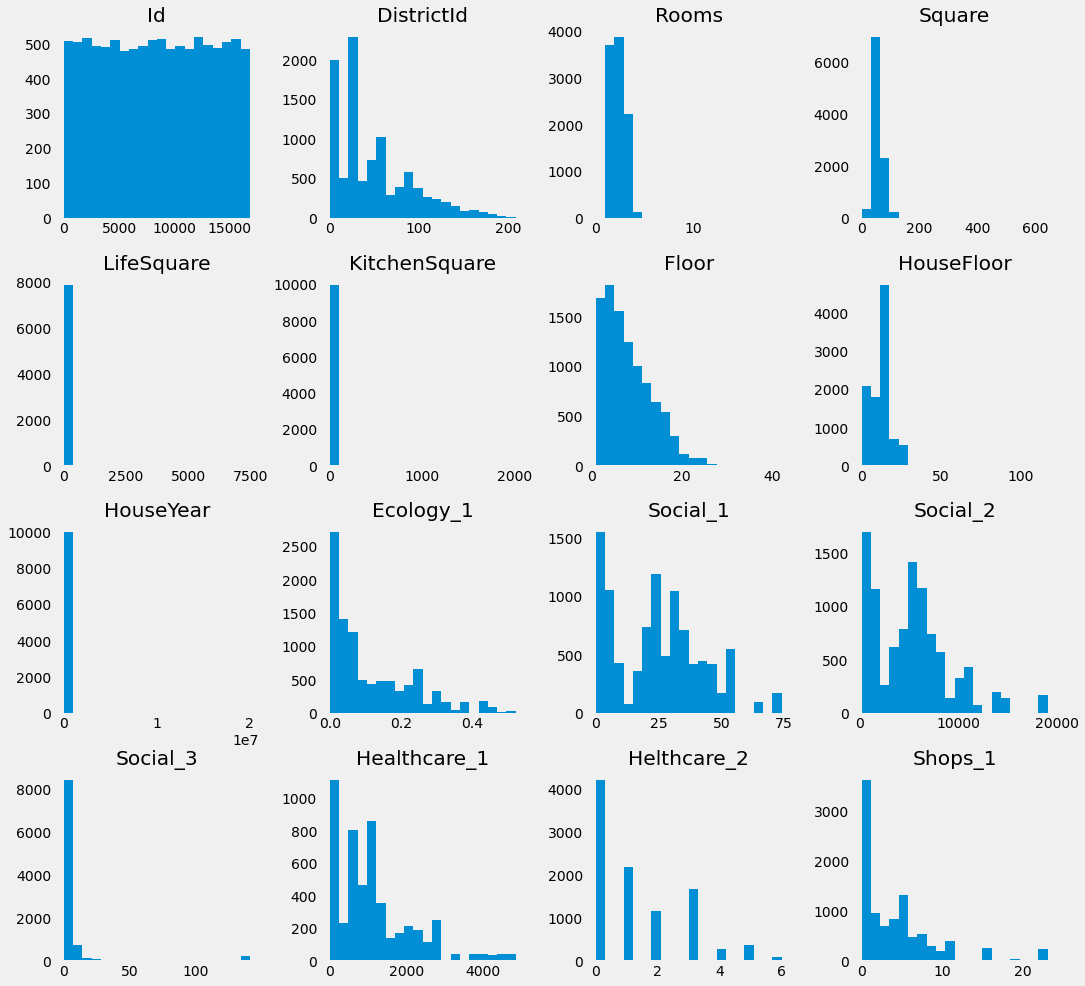

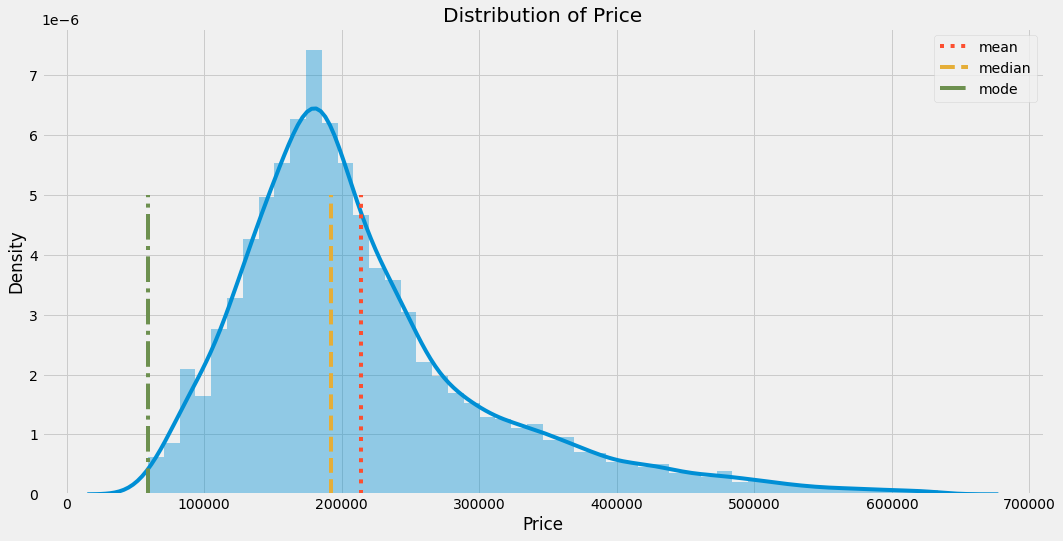

In [99]:
pipeline.plot(pipeline.train_data)

Целевая переменная вещественная, для ее предсказания используем регрессию, перед этим нормализуем ее стат метрики.

In [100]:
# подготовка признаков
pipeline.transform()
# масштабированный и нормализованный набор
df = DataFrame(pd.concat([pipeline.sc_train_data, pipeline.train_data[pipeline.target]], axis=1))

train resize
['Rooms', 'Square'] -> component_1
['Social_1', 'Social_2'] -> component_2
['HouseCountByDistrict', 'HeightByDistrict'] -> component_3
test resize
['Rooms', 'Square'] -> component_1
['Social_1', 'Social_2'] -> component_2
['HouseCountByDistrict', 'HeightByDistrict'] -> component_3


In [101]:
df.sample(5)

,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Healthcare_1,Shops_1,RoomsByDistrict,EcologyByDistrict,...,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,component_1,component_2,component_3,Price
9832,0.146964,0.622554,1.161607,0.229689,0.661517,0.393860,-0.643117,0.212843,0.076967,1.385663,...,0,1,0,1,0,1,0.186147,0.119612,0.179801,196626.876681
1008,0.033190,-1.482980,-0.879308,-0.390673,-0.440038,1.041992,-0.635449,2.158988,-1.085941,-0.575382,...,0,1,0,1,0,1,-1.738453,-0.591943,-1.112379,157045.918622
595,-0.806921,-0.167021,-0.675216,-1.321214,-1.156049,-0.696049,1.928268,-0.760229,-1.215153,-0.293403,...,0,1,0,1,0,1,-1.732763,-0.172954,-0.759034,145230.743740
5202,-0.141217,-1.219789,1.773881,0.539869,1.652916,1.447759,-0.479530,0.861558,0.033897,0.490049,...,0,1,0,1,0,1,-1.718431,1.041876,-0.814940,381912.162109
1769,2.872701,-1.482980,0.141150,-0.545763,1.873227,-0.382874,-0.561324,-1.084587,0.636886,0.001550,...,0,1,0,1,1,0,1.156663,-1.804864,-0.145892,202224.173139


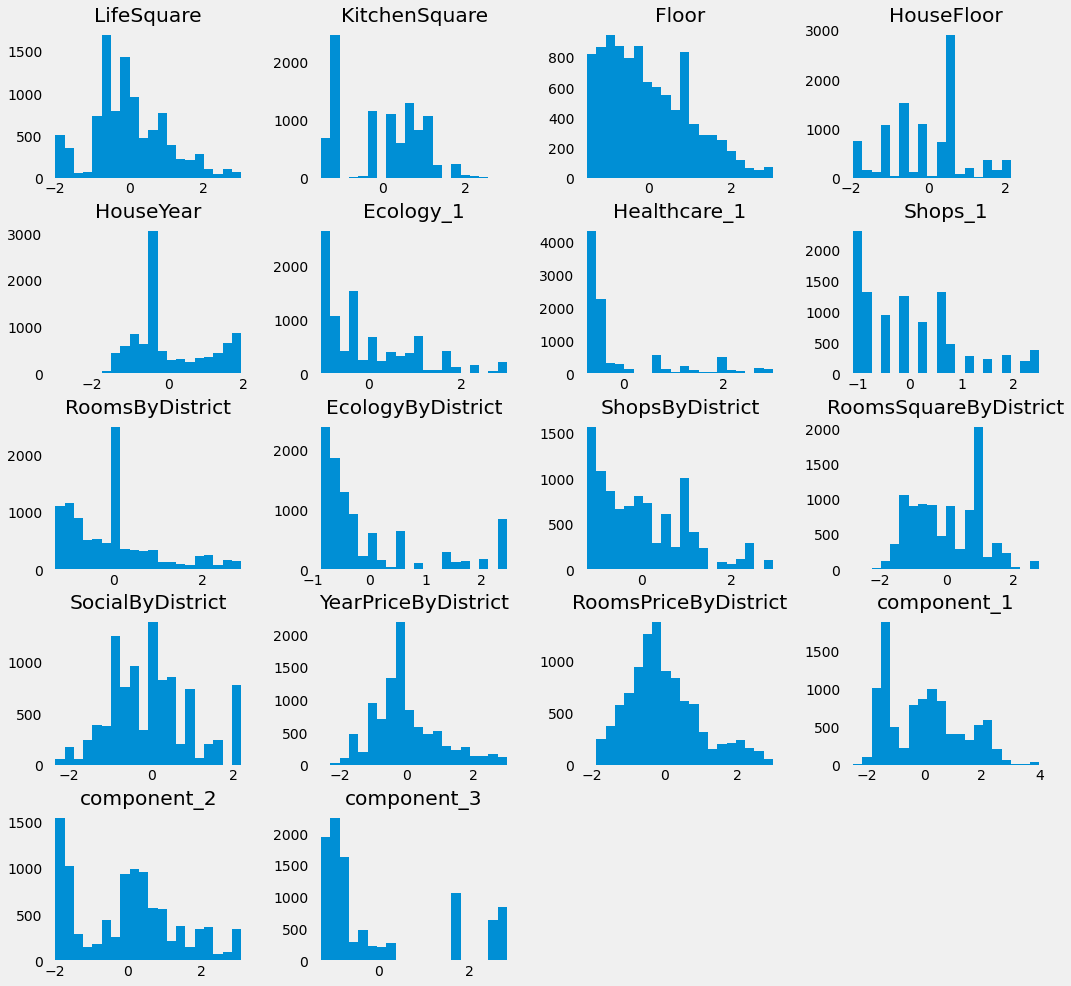

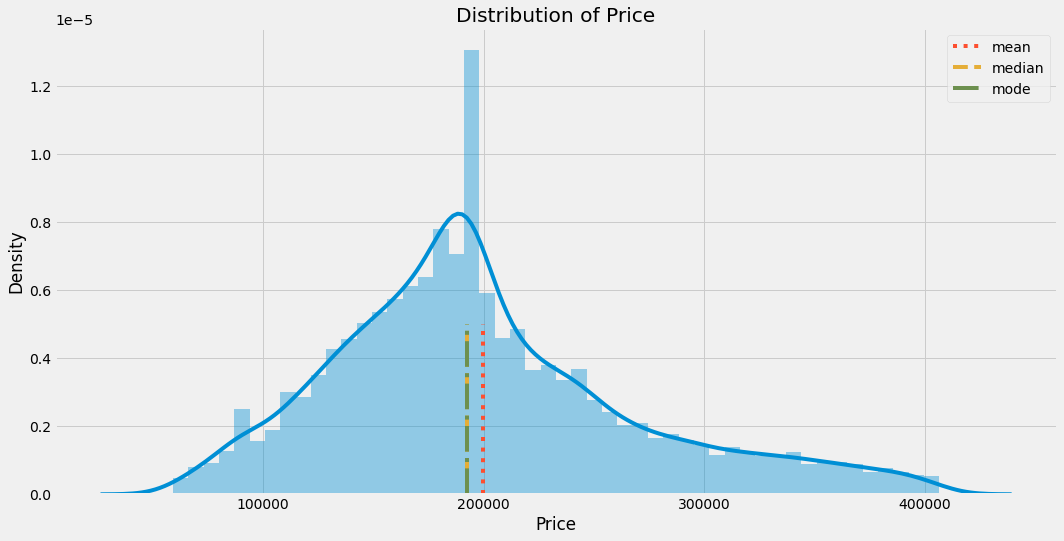

In [102]:
# распределение количественных признаков в исходных данных 
# целевой переменной и ее статистические данные
pipeline.plot(df)

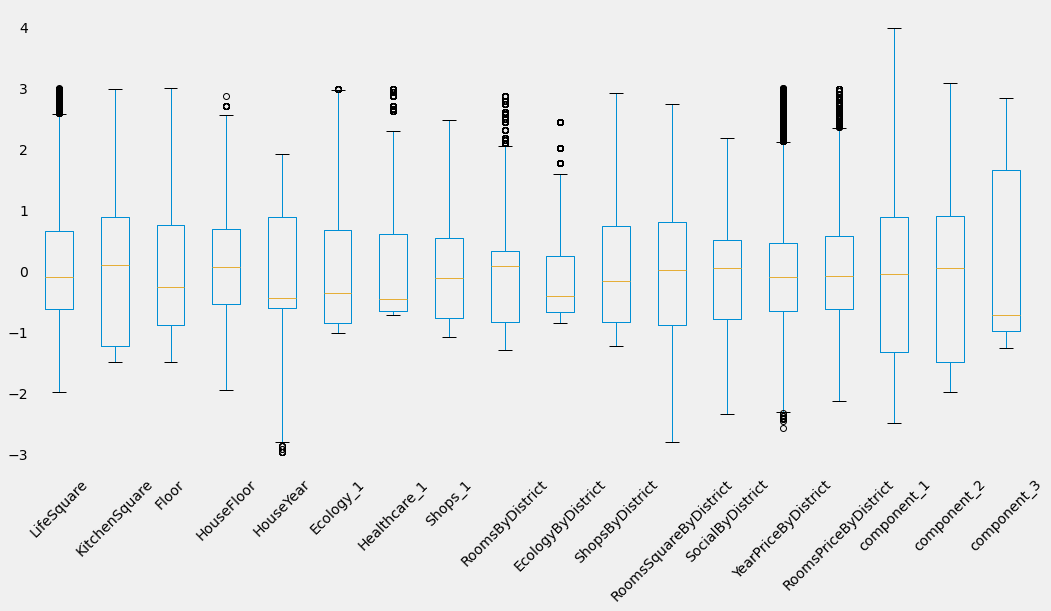

In [103]:
# визуализация выбросов после обработки признаков
pipeline.boxplot(pipeline.sc_train_data)

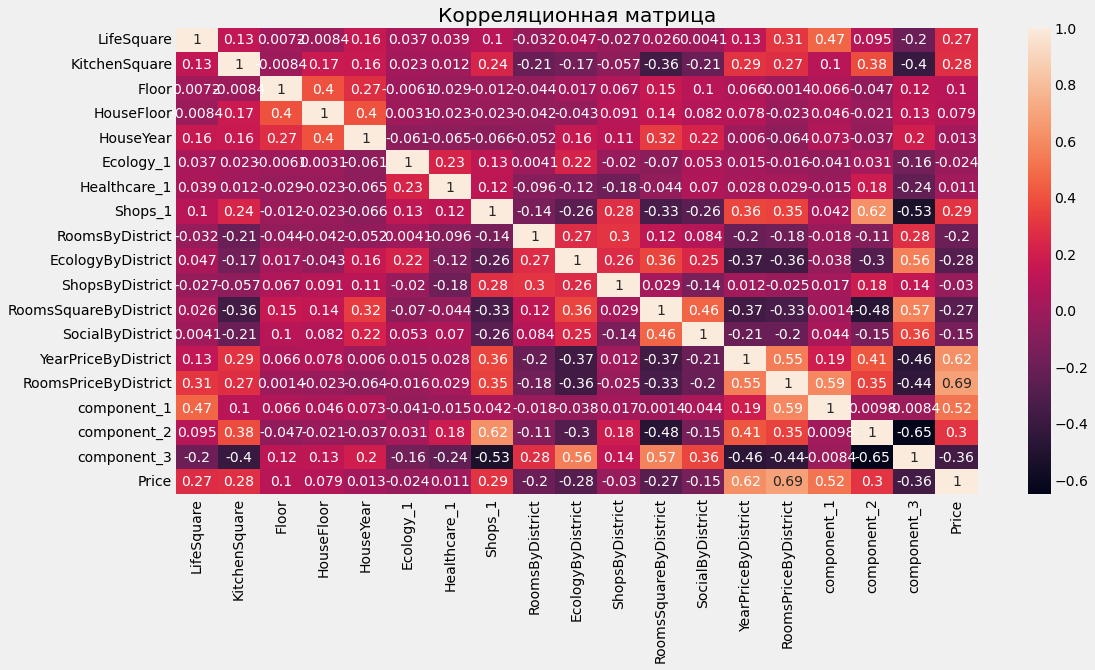

In [104]:
# корреляция признаков с целевой переменной их сильные взаимокорреляции устранены PCA
pipeline.corrplot(df)

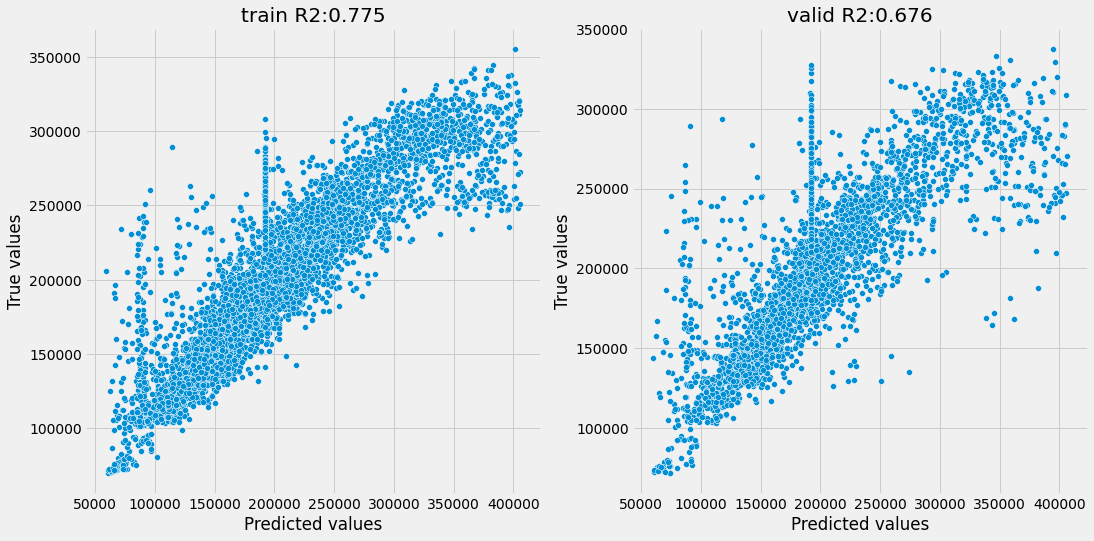

Wall time: 1.16 s


,name,value
14,RoomsPriceByDistrict,0.325492
13,YearPriceByDistrict,0.220410
27,component_1,0.148617
0,LifeSquare,0.055592
29,component_3,0.040356
28,component_2,0.029739
1,KitchenSquare,0.020172
11,RoomsSquareByDistrict,0.017932
4,HouseYear,0.013615
3,HouseFloor,0.012622


In [105]:
%%time
# определение оптимальных гипрепараметров модели
params = pipeline.search_param(pipeline.train_data)

print(params)

#params = {'criterion': 'friedman_mse', 'max_depth': 9, 'max_features': 9, 'n_estimators': 90, 'random_state': 42}
# обучение модели
model = pipeline.fit(RandomForestRegressor(**params))
# оценка результата обучения
pipeline.scatterplot(df)
# влияние признаков на процесс обучения
pipeline.importances(model)

In [106]:
# предсказание целевой переменой в test
pd.concat([pipeline.test_data, pd.DataFrame(data = pipeline.predict(model, pipeline.sc_test_data),\
                                            columns = [pipeline.target])], axis=1)   

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,200497.153232
1,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,236466.461876
2,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,131056.648968
3,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,243750.500994
4,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,137231.741222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B,237737.536862
4996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B,142358.855956
4997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B,269907.125606
4998,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,181317.420543
